# Imports

In [ ]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import contractions
from collections import Counter
import warnings
from sklearn.preprocessing import normalize

In [ ]:
nltk.data.path.append('/Users/r1/Desktop/Classification commentaires positifs et négatifs mémoire/nltk_data')

## **1.** Prétraitement

In [ ]:
# Initialisation des ressources
lemmatizer = WordNetLemmatizer()

# Mots de négation et intensificateurs importants à garder
important_words = {'not', 'no', 'never', 'none', "n't", 'very', 'so', 'too', 'most', 'just', 'only'}
base_stopwords = set(stopwords.words('english'))
stop_words = base_stopwords - important_words  # on retire les mots importants

#  Fonctions de prétraitement 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # par défaut


def expand_contractions(text):
    return contractions.fix(text)


def clean_text(text):
    text = re.sub(r'<.*?>', '', text)              # supprime les balises HTML
    text = re.sub(r'[^\w\s]', '', text)            # supprime la ponctuation
    text = text.lower()                            # passe en minuscules
    text = re.sub(r'\d+', '', text)                # supprime les chiffres
    text = re.sub(r'\s+', ' ', text).strip()       # supprime les espaces multiples
    return text

# Pipeline de prétraitement complet : nettoyage + tokenisation + POS-tagging + lemmatisation + stopword filtering
def preprocess_text(text):
    text = expand_contractions(text)     
    text = clean_text(text)
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)

    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged_tokens
        if word not in stop_words
    ]
    return ' '.join(lemmatized)

#Test du prétraitement
print(preprocess_text("I REALLY didn't like this movie!! It was <br> TOO long, with absolutely no plot. Just boring dialogues, and the acting? Terrible. I've seen better in student films..."))
#Résultat attendu : really not like movie too long absolutely no plot just boring dialogue acting terrible seen better student film

really not like movie too long absolutely no plot just bore dialogue act terrible see well student film


## **2.** Chargement des données

In [ ]:

# Chargement du dataset
df = pd.read_csv('/Users/r1/Desktop/Classification commentaires positifs et négatifs mémoire/IMDB Dataset.csv', nrows=5000)
print(f"Shape du dataframe : {df.shape}")
print(df.head(2))  # pour voir un petit échantillon

# Application du prétraitement
print("\nPrétraitement du corpus...")
df['processed_review'] = df['review'].apply(preprocess_text)

# Vérification d'un échantillon
print("\n Exemples après prétraitement :")
print(df[['review', 'processed_review']].sample(3)) #Affiche un échantillon de 3 lignes

# Mapping des labels
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print("Distribution des classes :")
print(df['label'].value_counts())


Shape du dataframe : (5000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive

Prétraitement du corpus...

 Exemples après prétraitement :
                                                 review  \
538   Sixth escapade for Freddy Krueger in which he ...   
2076  Pierce Brosnan has sipped his last Martini and...   
460   An intense thriller about a mute movie make-up...   

                                       processed_review  
538   sixth escapade freddy krueger finally manage k...  
2076  pierce brosnan sip last martini return outrage...  
460   intense thriller mute movie makeup artist witn...  
Distribution des classes :
label
0    2532
1    2468
Name: count, dtype: int64


## **3.** Analyse du corpus : comparaison avant/après prétraitement 

Nombre total de mots avant prétraitement : 1156177
Nombre total de mots après prétraitement : 612404
Nombre de mots uniques après prétraitement : 47166
Réduction globale après prétraitement : 47.03%
Nombre total de mots après prétraitement : 612404
Nombre de mots uniques : 47166
3074 mots couvrent 80% des occurrences
4865 mots couvrent 85% des occurrences
8518 mots couvrent 90% des occurrences
Top 20 des mots les plus fréquents : [('not', 12757), ('movie', 10036), ('film', 9038), ('one', 5210), ('make', 4387), ('like', 4244), ('see', 4039), ('so', 3878), ('get', 3649), ('good', 3611), ('just', 3512), ('would', 3173), ('time', 2860), ('go', 2819), ('very', 2798), ('watch', 2737), ('character', 2722), ('bad', 2598), ('even', 2459), ('story', 2457)]


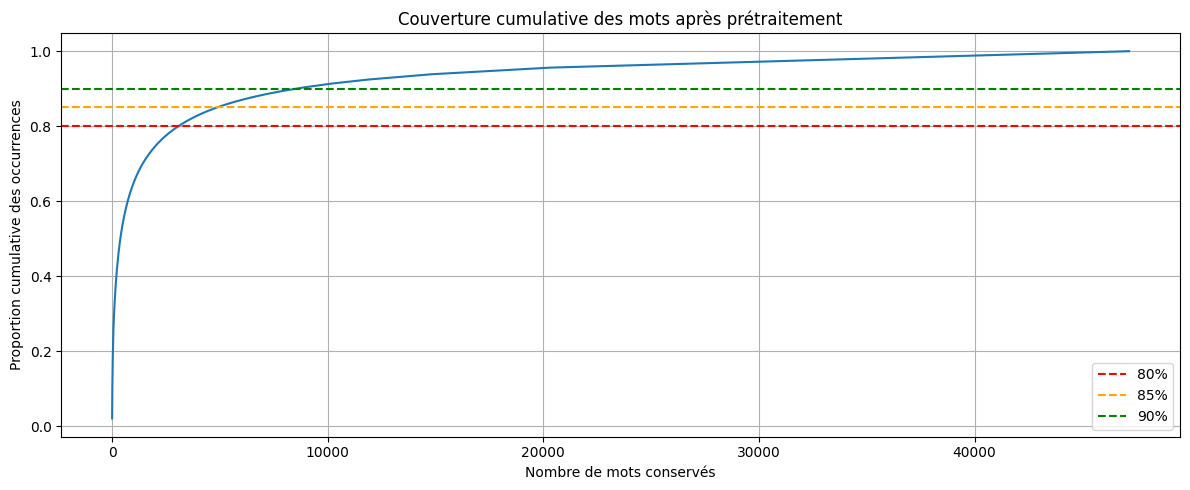

In [ ]:


# Statistiques avant prétraitement
raw_words = ' '.join(df['review']).split()
total_words_before = len(raw_words)

# Statistiques après prétraitement
cleaned_words = ' '.join(df['processed_review']).split()
total_words_after = len(cleaned_words)
unique_words_after = len(set(cleaned_words))

# Réduction de taille
reduction_ratio = 100 * (total_words_before - total_words_after) / total_words_before

print(f"Nombre total de mots avant prétraitement : {total_words_before}")
print(f"Nombre total de mots après prétraitement : {total_words_after}")
print(f"Nombre de mots uniques après prétraitement : {unique_words_after}")
print(f"Réduction globale après prétraitement : {reduction_ratio:.2f}%")

# Analyse fréquentielle après nettoyage 

# Comptage des mots
word_counts = Counter(cleaned_words)
total_words = sum(word_counts.values())
unique_words = len(word_counts)

# Tri des fréquences et cumul
sorted_counts = sorted(word_counts.values(), reverse=True)
cum_counts = np.cumsum(sorted_counts)

# Seuils de couverture
coverage_80 = np.argmax(cum_counts >= 0.80 * total_words) + 1
coverage_85 = np.argmax(cum_counts >= 0.85 * total_words) + 1
coverage_90 = np.argmax(cum_counts >= 0.90 * total_words) + 1

# Affichage des stats
print(f"Nombre total de mots après prétraitement : {total_words}")
print(f"Nombre de mots uniques : {unique_words}")
print(f"{coverage_80} mots couvrent 80% des occurrences")
print(f"{coverage_85} mots couvrent 85% des occurrences")
print(f"{coverage_90} mots couvrent 90% des occurrences")
print("Top 20 des mots les plus fréquents :", word_counts.most_common(20))

# Courbe de couverture cumulative

plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, len(cum_counts) + 1), cum_counts / total_words)
plt.axhline(0.80, color='r', linestyle='--', label="80%")
plt.axhline(0.85, color='orange', linestyle='--', label="85%")
plt.axhline(0.90, color='g', linestyle='--', label="90%")
plt.xlabel("Nombre de mots conservés")
plt.ylabel("Proportion cumulative des occurrences")
plt.title("Couverture cumulative des mots après prétraitement")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **4.** Split train/test

In [ ]:

X_text = df['processed_review']
y = df['label'].values
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42, stratify=y)
print(f"\nTaille X_train : {X_text_train.shape}, X_test : {X_text_test.shape}")
print("\nDistribution dans y_train :")
print(pd.Series(y_train).value_counts())
print("Distribution dans y_test :")
print(pd.Series(y_test).value_counts())



Taille X_train : (3500,), X_test : (1500,)

Distribution dans y_train :
0    1772
1    1728
Name: count, dtype: int64
Distribution dans y_test :
0    760
1    740
Name: count, dtype: int64


## **5.** Vectorisation BoW 

In [ ]:

vectorizer = CountVectorizer(max_features=3074)
X_train = vectorizer.fit_transform(X_text_train).toarray()
X_test = vectorizer.transform(X_text_test).toarray()


# Checkpoints
print(f"X_train shape : {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"Nombre de mots dans le vocabulaire : {len(vectorizer.get_feature_names_out())}")
print("Exemples de mots du vocabulaire :", vectorizer.get_feature_names_out()[:20])


X_train shape : (3500, 3074)
X_test shape : (1500, 3074)
Nombre de mots dans le vocabulaire : 3074
Exemples de mots du vocabulaire : ['abandon' 'ability' 'able' 'aboard' 'absence' 'absolute' 'absolutely'
 'absorb' 'absurd' 'abuse' 'academy' 'accent' 'accept' 'acceptable'
 'accident' 'accidentally' 'accompany' 'accomplish' 'accord' 'account']


## **6.** Normalisation avant KPCA

In [ ]:


X_train_norm = normalize(X_train, norm='l2')
X_test_norm = normalize(X_test, norm='l2')

# Checkpoints
print("Norme du premier vecteur X_train_norm :", np.linalg.norm(X_train_norm[0]))
print("Norme moyenne X_train_norm :", np.mean(np.linalg.norm(X_train_norm, axis=1)))
print("Shape X_train_norm :", X_train_norm.shape)

Norme du premier vecteur X_train_norm : 0.9999999999999999
Norme moyenne X_train_norm : 1.0
Shape X_train_norm : (3500, 3074)


## **7.** Modélisation et résultats


🔍 KNN — Sans réduction

🔍 KNN — PCA
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ............................reduce__n_components=50; total time=   1.4s
[CV] END ............................reduce__n_components=50; total time=   1.4s
[CV] END ............................reduce__n_components=50; total time=   1.7s
[CV] END ...........................reduce__n_components=100; total time=   2.4s
[CV] END ...........................reduce__n_components=100; total time=   2.4s
[CV] END ............................reduce__n_components=50; total time=   1.7s
[CV] END ............................reduce__n_components=50; total time=   1.6s
[CV] END ...........................reduce__n_components=100; total time=   2.2s
[CV] END ...........................reduce__n_components=100; total time=   2.4s
[CV] END ...........................reduce__n_components=100; total time=   2.5s
[CV] END ...........................reduce__n_components=300; total time=   3.4s
[CV] END ...

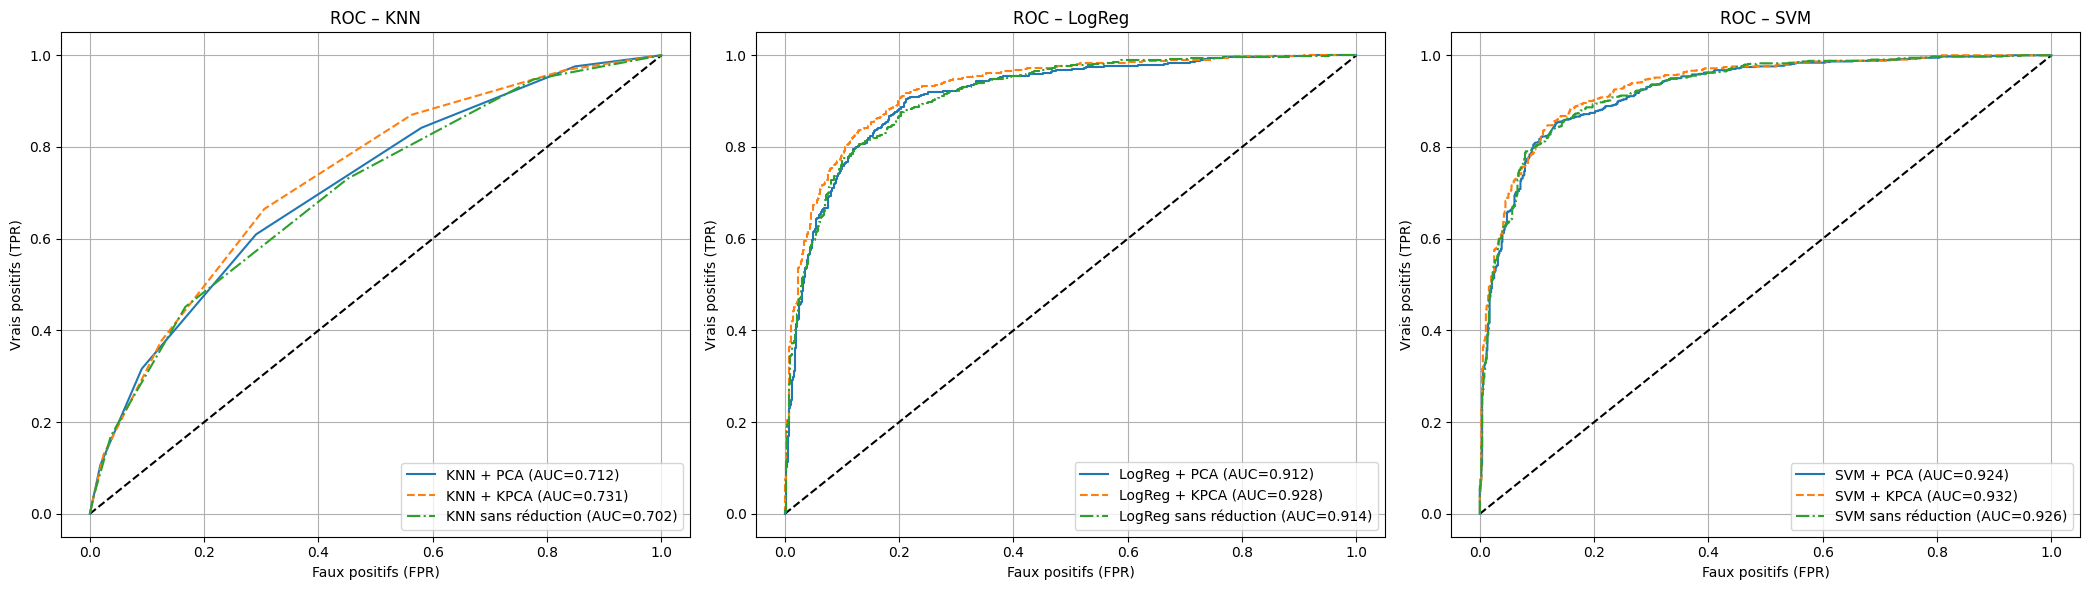

In [ ]:
#  Définition des hyperparamètres globaux 
components_range = [50, 100, 300, 700]  # première passe rapide

#  Liste des modèles testés 
MODELS = {
    "KNN": KNeighborsClassifier(),
    "LogReg": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='rbf', probability=True)
}


# Fonction pour évaluer un modèle sans réduction
def eval_no_reduction(model_name, model, X_train, y_train):
    """Évalue un modèle sur les données brutes via validation croisée."""
    f1_scores = cross_val_score(model, X_train, y_train, scoring="f1", cv=5, n_jobs=-1)
    return np.mean(f1_scores), model.fit(X_train, y_train)


# Fonction pour faire un GridSearch avec PCA ou KPCA
def gridsearch_reduction(model_name, model, X_train, y_train, reducer):
    """Effectue un GridSearch pour sélectionner le meilleur nombre de composantes."""
    if reducer == "pca":
        pipe = Pipeline([
            ("reduce", PCA(random_state=42)),
            ("clf", model)
        ])
    elif reducer == "kpca":
        pipe = Pipeline([
            ("reduce", KernelPCA(kernel="cosine", n_jobs=-1)),
            ("clf", model)
        ])
    else:
        raise ValueError("reducer must be 'pca' or 'kpca'")

    param_grid = {"reduce__n_components": components_range}

    grid = GridSearchCV(pipe, param_grid, scoring="f1", cv=5, n_jobs=-1, verbose=2)
    grid.fit(X_train, y_train)
    return grid

# Phase 1 : Tests principaux
results = []
best_models = {}

for name, model in MODELS.items():
    print(f"\n {name} — Sans réduction")
    score, fitted = eval_no_reduction(name, model, X_train, y_train)
    results.append({
        "Modèle": name,
        "Réduction": "Aucune",
        "n_composantes": "—",
        "F1": score
    })
    best_models[f"{name}_none"] = fitted

    print(f"\n {name} — PCA")
    pca_grid = gridsearch_reduction(name, model, X_train, y_train, "pca")
    results.append({
        "Modèle": name,
        "Réduction": "PCA",
        "n_composantes": pca_grid.best_params_["reduce__n_components"],
        "F1": pca_grid.best_score_
    })
    best_models[f"{name}_pca"] = pca_grid.best_estimator_

    print(f"\n {name} — KPCA (cosine)")
    kpca_grid = gridsearch_reduction(name, model, X_train_norm, y_train, "kpca")
    results.append({
        "Modèle": name,
        "Réduction": "Kernel PCA (cosine)",
        "n_composantes": kpca_grid.best_params_["reduce__n_components"],
        "F1": kpca_grid.best_score_
    })
    best_models[f"{name}_kpca"] = kpca_grid.best_estimator_

# Résultats initiaux
df_results = pd.DataFrame(results)
print("\n Résumé initial :")
print(df_results)


# Phase 2 : Recherche étendue si besoin
# Nouvelle grille pour étendre la recherche
components_range_extended = [1000, 1500, 2000, 2500]

def extended_gridsearch_if_needed(model_name, model, reducer, prev_best_n, X_train,X_train_norm , y_train):
    """Relance une recherche avec plus de composantes si borne max atteinte."""
    if prev_best_n == 700:
        print(f"\n Extension de recherche pour {model_name} + {reducer.upper()} au-delà de 700 composantes...")

        if reducer == "pca":
            pipe = Pipeline([
                ("reduce", PCA(random_state=42)),
                ("clf", model)
            ])
            X_input = X_train
        elif reducer == "kpca":
            pipe = Pipeline([
                ("reduce", KernelPCA(kernel="cosine", n_jobs=-1)),
                ("clf", model)
            ])
            X_input = X_train_norm
        else:
            raise ValueError()

        param_grid = {"reduce__n_components": components_range_extended}

        grid = GridSearchCV(pipe, param_grid, scoring="f1", cv=5, verbose=2, n_jobs=-1)
        grid.fit(X_input, y_train)

        return {
            "Modèle": model_name,
            "Réduction": "Kernel PCA (cosine)" if reducer == "kpca" else "PCA",
            "n_composantes": grid.best_params_["reduce__n_components"],
            "F1": grid.best_score_
        }, grid.best_estimator_
    return None, None

# Check et relance ciblée
old_results = pd.DataFrame(results)

for model_name, model_class in MODELS.items():
    # LogReg + KPCA
    if old_results.loc[(old_results["Modèle"] == model_name) & (old_results["Réduction"] == "Kernel PCA (cosine)"), "n_composantes"].values[0] == 700:
        res, fitted = extended_gridsearch_if_needed(model_name, model_class, "kpca", 700, X_train, X_train_norm, y_train)
        if res:
            results.append(res)
            best_models[f"{model_name}_kpca_ext"] = fitted

    # SVM + PCA
    if model_name == "SVM" and old_results.loc[(old_results["Modèle"] == model_name) & (old_results["Réduction"] == "PCA"), "n_composantes"].values[0] == 700:
        res, fitted = extended_gridsearch_if_needed(model_name, model_class, "pca", 700, X_train,X_train_norm, y_train)
        if res:
            results.append(res)
            best_models[f"{model_name}_pca_ext"] = fitted

# Résultats finaux
df_results_final = pd.DataFrame(results)
print("\n✅ Résultats finaux :")
print(df_results_final)
df_results_final.to_csv("resume_f1_models_final.csv", index=False)


# Phase 3 : Courbes ROC
def plot_roc(ax, model, X_test, y_test, label, style):
    """Trace la courbe ROC pour un modèle donné."""
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    ax.plot(fpr, tpr, style, label=f"{label} (AUC={auc_score:.3f})")

# Plot ROC pour chaque famille de modèles
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for i, model_name in enumerate(MODELS.keys()):
    ax = axes[i]
    ax.plot([0, 1], [0, 1], 'k--')

    plot_roc(ax, best_models[f"{model_name}_pca"], X_test, y_test, f"{model_name} + PCA", '-')
    plot_roc(ax, best_models[f"{model_name}_kpca"], X_test_norm, y_test, f"{model_name} + KPCA", '--')
    plot_roc(ax, best_models[f"{model_name}_none"], X_test, y_test, f"{model_name} sans réduction", '-.')

    ax.set_title(f"ROC – {model_name}")
    ax.set_xlabel("Faux positifs (FPR)")
    ax.set_ylabel("Vrais positifs (TPR)")
    ax.grid(True)
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()
